In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 10 17:46:30 2019

@author: ct513
"""

'IMPORT DATA'

""" The script imports the EEG data from MATLAB (in .mat format). The main scope is that of grouping
together events with the same tone (i.e., T650_1, T650_2, etc.) and same state (i.e., awake night =WNGT,
N2, N3, and REM. The EEG data are saved in the folder EEG_data_for_analysis, whereas the evokeds data,
which are mainly used for the plotting of the ERPs are saved in the folder RDMs_and_distances_results.
This means that there is no need to run the script again, since its outputs are already saved in the dedicated folders.
To load these outputs, use the function np.load"""


data_path='C:\AnatArzData\Data\ica_interpolated'
data_path1='C:\AnatArzData\Data\RDMs_and_distances_results'
data_path2='C:\AnatArzData\Data\EEG_data_for_analysis'

# Load all modules..
import numpy as np
import os
import mne
from mne import io
from tqdm import tqdm
import gc
import matplotlib
import matplotlib.pyplot as plt

"""The first 5 subjects were presented with 12 events and subject 01 was (mistakingly)
presented with a sound of 1985Hz rather than of 1098Hz. From subject 06 onwards
participants were presented with 10 tones. In the analysis that will follow,
we will consider only 9 tones, by excluding the tone T500, which happened to have
same frequency as the adaptor A500 (i.e., the risk was to have a strong habituation
effect) """

"""Note that subject 18 is missing because the participant did not fall asleep"""

###############################################################################
###### Montage
#channel_data=pd.ExcelFile(os.path.join(data_path,'Channels_location.xlsx'))
#table_channel=channel_data.parse('Sheet1')
#channel_pos=DataFrame(table_channel,columns=['channel','Y','X','Z','sph_theta','sph_phi','sph_radius','theta','radius'])
#name=channel_pos['channel'].tolist()
#chan_types = 'eeg'
#XYZ_chpos = channel_pos[channel_pos.columns[1:4]]
#coord_XYZ=XYZ_chpos.values
#XY_chpos = channel_pos[channel_pos.columns[1:3]]
#coord_XY=XY_chpos.values
#index=np.array([4,5,6,7,8,9,11,12,13,14,15,17,18,20,21,22,24,25,26,28,29,30,31,
#                32,33,35,36,37,38,39,41,42,43,44,47,48,49,52,53,54,55,56,57,59,
#                60,61,62,63,64,67,68,69,72,73,74,77,78,79,80,81,82,85,86,87,88,
#                89,92,93,94,95,98,99,100,102,103,104,105,106,107,108,110,111,112,
#                113,114,117,118,119,120,124,125,126])
#montage1010 = mne.channels.Montage(coord_XYZ,name,'GSN-HydroCel-128',index)
#info = create_info(ch_names=name, sfreq=500, ch_types=chan_types,montage=montage1010) # try with 250
#montage1010.plot()
#connectivity, ch_names = find_ch_connectivity(info, ch_type='eeg')
##connectivity=mne.channels.read_ch_connectivity('C:\\Users\\ct513\\connectivity.mat') #ask Stani to compute it with FieldTrip
#plt.imshow(connectivity.toarray(), cmap='gray', origin='lower', interpolation='nearest')

""" Let's define the main variables: subjects and tones """

subjects = ['32','35','38']

tones = ['T650','T1098','T2413','T3137','O650','O1428','O1856','O2413','O3137']

In [2]:
###############################################################################
""" Import EEG data from MATLAB format """
###############################################################################
def _import(subj_id):
    gc.collect()
    """ Define paths """

    subject_setfile_wake_n = data_path + '/s_' + subj_id + '_wake_night_int.set'   # wake night
    subject_setfile_sleep = data_path + '/s_' + subj_id + '_sleep_int.set'         # sleep (sleep1_rsam only subject 5)
    #subject_setfile_wake_m = data_path + '/s_' + subj_id + '_wake_morning_int.set' # wake morning

    """ Read MATLAB files """

    globals()['epochs_w_ngt'+subj_id] = io.read_epochs_eeglab(subject_setfile_wake_n, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None) # epochs_w_ngt.info to see the data structure
    globals()['epochs_sleep'+subj_id] = io.read_epochs_eeglab(subject_setfile_sleep, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None)
    #globals()['epochs_w_m'+subj_id] = mne.read_epochs_eeglab(subject_setfile_wake_m, events=None, event_id=None, montage=None, eog=(),verbose=None, uint16_codec=None)

    """ For each state create a loop which loads and categorize the events opportunely """
    """ Note that the except KeyError was introduced because some events were missing,
    causing a KeyError to appear """

    ########################
    #AWAKE NIGHT
    for value, j in enumerate(tones):
        globals()['ep_wakengt_'+subj_id+'_'+j]=[] #list of epochs data categorized by state, subject, and tone
        globals()['EEG_WN_'+subj_id+'_'+j]=[] # list of EEG data categorized by state, subject, and tone
        try:
            for k in range(0,10): # note that the MATLAB EEG file is of the shape (n trials, n electrodes, n time points)
                try:

                    """ List of epochs """
                    globals()['ep_wakengt_'+subj_id+'_'+str(j)].append(globals()['epochs_w_ngt'+subj_id][str(j)+'_'+ str(k)]) # in the IPython console type: i.e, ep_wngt_02_T500
                    globals()['ep_wakenight_'+subj_id+'_'+str(j)]=mne.concatenate_epochs(globals()['ep_wakengt_'+subj_id+'_'+str(j)])

                    """ List of EEG data """
                    globals()['EEG_WN_'+subj_id+'_'+j].append(np.swapaxes(globals()['epochs_w_ngt'+subj_id][str(j)+'_'+ str(k)].get_data(),1,2))
                    globals()['EEG_WNGT_'+subj_id+'_'+j]=np.concatenate(globals()['EEG_WN_'+subj_id+'_'+str(j)], axis=0)

                    """ Save EEG data """
                    #np.save(os.path.join(data_path2,'EEG_WNGT_'+subj_id+'_'+j),globals()['EEG_WNGT_'+subj_id+'_'+j])

                except KeyError:
                    continue

            globals()['evoked_wngt_'+subj_id+'_'+str(j)]=(globals()['ep_wakenight_'+subj_id+'_'+str(j)]).average() #average all epochs corresponding to a tone for each subject

            """ Save evoked data """
            np.save(os.path.join(data_path1,'evoked_wngt_'+subj_id+'_'+str(j)),globals()['evoked_wngt_'+subj_id+'_'+str(j)])

        except KeyError:
            continue
    ##########################
    # SLEEP
    # stages: N1, N2, N3
    for i in range(1,4): # number corresponding to the N stage (between 1 and 3)
        for value, j in enumerate(tones):
            globals()['ep_sleepN_'+subj_id+'_N'+str(i)+str(j)]=[]
            globals()['EEG_N_'+subj_id+'_N'+str(i)+str(j)]=[]
            try:
                for k in range(0,10):
                    try:

                        """ List of epochs """
                        globals()['ep_sleepN_'+subj_id+'_N'+str(i)+str(j)].append(globals()['epochs_sleep'+subj_id]['N'+str(i)+str(j)+'_'+str(k)])
                        globals()['evoked_'+subj_id+'_N'+str(i)+str(j)]=mne.concatenate_epochs(globals()['ep_sleepN_'+subj_id+'_N'+str(i)+str(j)])
                        ev = globals()['evoked_'+subj_id+'_N'+str(i)+str(j)]

                        """ List of EEG data """
                        globals()['EEG_N_'+subj_id+'_N'+str(i)+str(j)].append(np.swapaxes(globals()['epochs_sleep'+subj_id]['N'+str(i)+str(j)+'_'+str(k)].get_data(),1,2))
                        globals()['EEG_SN_'+subj_id+'_N'+str(i)+str(j)]=np.concatenate(globals()['EEG_N_'+subj_id+'_N'+str(i)+str(j)], axis=0)

                        """ Save EEG data """
                        #np.save(os.path.join(data_path2,'EEG_SN_'+subj_id+'_N'+str(i)+str(j)),globals()['EEG_SN_'+subj_id+'_N'+str(i)+str(j)])

                    except KeyError:
                        continue

                globals()['evoked_sleep'+subj_id+'_N'+str(i)+str(j)]=(globals()['evoked_'+subj_id+'_N'+str(i)+str(j)]).average() #to plot!!   #evoked_sleep06_N1T500

                toplot =    globals()['evoked_sleep'+subj_id+'_N'+str(i)+str(j)]
                """ Save evoked data """
                np.save(os.path.join(data_path1,'evoked_SN_'+subj_id+'_N'+str(i)+str(j)),globals()['evoked_sleep'+subj_id+'_N'+str(i)+str(j)])
            except KeyError:
                continue
                #####
    # stages: Rp, Rt
    REM=['Rp','Rt']

    for value, i in enumerate(REM):
        for value, j in enumerate(tones):
            globals()['ep_sleepREM_'+subj_id+'_'+str(i)+str(j)]=[]
            globals()['EEG_REM_'+subj_id+'_'+str(i)+str(j)]=[]
            globals()['evoked_sleep'+subj_id+'_REM'+str(j)]=[]#group Rt and Rp together
            globals()['EEG_bothREM_'+subj_id+'_'+str(j)]=[]#group Rt and Rp together
            try:
                for k in range(0,10):
                    try:

                        """ List of epochs """
                        globals()['ep_sleepREM_'+subj_id+'_'+str(i)+str(j)].append(globals()['epochs_sleep'+subj_id][str(i)+str(j)+'_'+ str(k)])
                        globals()['evoked_'+subj_id+'_'+str(i)+str(j)]=mne.concatenate_epochs(globals()['ep_sleepREM_'+subj_id+'_'+str(i)+str(j)])

                        """ List of EEG data """
                        globals()['EEG_REM_'+subj_id+'_'+str(i)+str(j)].append(np.swapaxes(globals()['epochs_sleep'+subj_id][str(i)+str(j)+'_'+ str(k)].get_data(),1,2))
                        globals()['EEG_SREM_'+subj_id+'_'+str(i)+str(j)]=np.concatenate(globals()['EEG_REM_'+subj_id+'_'+str(i)+str(j)], axis=0)

                        """ Save EEG data """
                        np.save(os.path.join(data_path2,'EEG_SREM_'+subj_id+'_'+str(i)+str(j)),globals()['EEG_SREM_'+subj_id+'_'+str(i)+str(j)])

                    except KeyError:
                        continue

                globals()['evoked_sleep'+subj_id+'_'+str(i)+str(j)]=(globals()['evoked_'+subj_id+'_'+str(i)+str(j)]).average()

                """ Save evoked data """
                np.save(os.path.join(data_path1,'evoked_SREM_'+subj_id+'_'+str(i)+str(j)),globals()['evoked_sleep'+subj_id+'_'+str(i)+str(j)])

            except KeyError:
                continue

                ##########################
    # AWAKE MORNING
    #    evoked_wmorning=[]
    #    for value, j in enumerate(tones):
    #        globals()['ep_wakem_'+subj_id+'_'+str(j)]=[]
    #        globals()['EEG_WM_'+subj_id+'_'+str(j)]=[]
    #
    #        try:
    #            for k in range(0,10): # check EEG and baseline
    #                try:
    #
    #                    """ List of epochs """
    #                    globals()['ep_wakem_'+subj_id+'_'+str(j)].append(globals()['epochs_w_m'+subj_id][str(j)+'_'+ str(k)])
    #                    globals()['evoked_wm_'+subj_id+'_'+str(j)]= mne.concatenate_epochs(globals()['ep_wakem_'+subj_id+'_'+str(j)])
    #
    #                    """ List of EEG data """
    #                    globals()['EEG_WM_'+subj_id+'_'+str(j)].append(np.swapaxes(globals()['ep_wm_'+subj_id+'_'+str(j)].get_data(),1,2))
    #                    globals()['EEG_WMNG_'+subj_id+'_'+str(j)]=np.concatenate((globals()['EEG_WM_'+subj_id+'_'+str(j)]), axis=0)
    #
    #                    """ Save EEG data """
    #                    #np.save(os.path.join(data_path2,'EEG_WMNG_'+subj_id+'_'+j),globals()['EEG_WMNG_'+subj_id+'_'+j])
    #
    #                except KeyError:
    #                    continue
    #
    #            globals()['evoked_wmorning_'+subj_id+'_'+str(j)]=(globals()['evoked_wm_'+subj_id+'_'+str(j)]).average() #to plot!!
    #
    #            """ Save evoked data """
    #            np.save(os.path.join(data_path1,'evoked_wmorning_'+subj_id+'_'+str(j)),globals()['evoked_wmorning_'+subj_id+'_'+str(j)])
    #
    #        except KeyError:
    #            continue
    return
###############################################################################
######### Load data and define conditions for each subject ####################
###############################################################################
with tqdm(total=len(subjects)) as pbar:
    for s, subject in enumerate(subjects):
        _import(subject)
        pbar.write('processed: %d' %s)
        pbar.update(1)

  0%|          | 0/2 [00:00<?, ?it/s]

Extracting parameters from C:\AnatArzData\Data\ica_interpolated\s_35_wake_night_int.set...


C:\Users\Sharon\AppData\Local\Temp\ipykernel_10828\3267804869.py:14: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  globals()['epochs_w_ngt'+subj_id] = io.read_epochs_eeglab(subject_setfile_wake_n, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None) # epochs_w_ngt.info to see the data structure


Not setting metadata
4779 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from C:\AnatArzData\Data\ica_interpolated\s_35_sleep_int.set...


C:\Users\Sharon\AppData\Local\Temp\ipykernel_10828\3267804869.py:15: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  globals()['epochs_sleep'+subj_id] = io.read_epochs_eeglab(subject_setfile_sleep, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None)


Not setting metadata
28937 matching events found
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
24 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
48 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
72 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
96 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
120 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
140 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
160 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
181 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
204 matching events found
No baseline correction applied
0 bad epochs dropp

 50%|█████     | 1/2 [02:34<02:34, 154.09s/it]

processed: 0
Extracting parameters from C:\AnatArzData\Data\ica_interpolated\s_38_wake_night_int.set...


C:\Users\Sharon\AppData\Local\Temp\ipykernel_10828\3267804869.py:14: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  globals()['epochs_w_ngt'+subj_id] = io.read_epochs_eeglab(subject_setfile_wake_n, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None) # epochs_w_ngt.info to see the data structure


Not setting metadata
4747 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from C:\AnatArzData\Data\ica_interpolated\s_38_sleep_int.set...


C:\Users\Sharon\AppData\Local\Temp\ipykernel_10828\3267804869.py:15: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  globals()['epochs_sleep'+subj_id] = io.read_epochs_eeglab(subject_setfile_sleep, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None)


Not setting metadata
24419 matching events found
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
24 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
48 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
71 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
94 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
118 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
141 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
160 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
178 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
201 matching events found
No baseline correction applied
0 bad epochs dropp

100%|██████████| 2/2 [04:04<00:00, 122.41s/it]

processed: 1


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


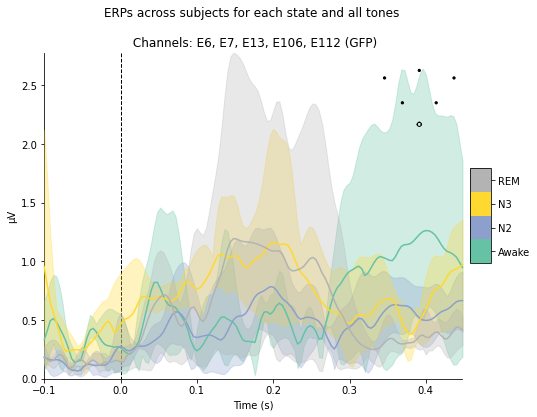

[<Figure size 576x432 with 3 Axes>]

In [2]:
###############################################################################
############ Plot grand average ERP for all tones #############################
""" First, for each state, plot the ERPs averaged across all tones (1 graph)"""

state_ERP_WNGT = []
state_ERP_N2 = []
state_ERP_N3 = []
state_ERP_REM = []
for s, subject in enumerate(subjects):
    globals()['ERP_WNGT_{}'.format(subject)]=[]
    globals()['ERP_N2_{}'.format(subject)]=[]
    globals()['ERP_N3_{}'.format(subject)]=[]
    globals()['ERP_REM_Rp{}'.format(subject)] = []
    globals()['ERP_REM_Rt{}'.format(subject)] = []
    globals()['ERP_REM_{}'.format(subject)]=[]
    for value, j in enumerate(tones):
        """ Load saved data """
        """ Awake night """
        globals()['evoked_wngt_{}_{}'.format(subject,j)] = np.load(os.path.join(data_path1,'evoked_wngt_'+subject+'_'+j+'.npy'),allow_pickle = True)
        globals()['ERP_WNGT_{}'.format(subject)].append((globals()['evoked_wngt_{}_{}'.format(subject,j)].flatten())[0])
        """ Non REM sleep """
        globals()['evoked_SN_{}_N2{}'.format(subject,j)] = np.load(os.path.join(data_path1,'evoked_SN_'+subject+'_N2'+j+'.npy'),allow_pickle = True)
        globals()['ERP_N2_{}'.format(subject)].append((globals()['evoked_SN_{}_N2{}'.format(subject,j)].flatten())[0])
        globals()['evoked_SN_{}_N3{}'.format(subject,j)] = np.load(os.path.join(data_path1,'evoked_SN_{}_N3{}.npy'.format(subject,j)),allow_pickle = True)
        globals()['ERP_N3_{}'.format(subject)].append((globals()['evoked_SN_{}_N3{}'.format(subject,j)].flatten())[0])
        """ REM """
        globals()['evoked_SREM_{}_Rp{}'.format(subject,j)] = np.load(os.path.join(data_path1,'evoked_SREM_'+subject+'_Rp'+j+'.npy'),allow_pickle = True)
        globals()['evoked_SREM_{}_Rt{}'.format(subject,j)] = np.load(os.path.join(data_path1,'evoked_SREM_'+subject+'_Rt'+j+'.npy'),allow_pickle = True)
        globals()['ERP_REM_Rp{}'.format(subject)].append((globals()['evoked_SREM_{}_Rp{}'.format(subject,j)].flatten())[0])
        globals()['ERP_REM_Rt{}'.format(subject)].append((globals()['evoked_SREM_{}_Rt{}'.format(subject,j)].flatten())[0])
    state_ERP_WNGT.append(mne.grand_average(globals()['ERP_WNGT_{}'.format(subject)]))
    np.save(os.path.join(data_path1,'state_ERP_WNGT'),state_ERP_WNGT)
    state_ERP_N2.append(mne.grand_average(globals()['ERP_N2_{}'.format(subject)]))
    np.save(os.path.join(data_path1,'state_ERP_N2'),state_ERP_N2)
    state_ERP_N3.append(mne.grand_average(globals()['ERP_N3_{}'.format(subject)]))
    np.save(os.path.join(data_path1,'state_ERP_N3'),state_ERP_N3)
    globals()['ERP_REM_{}'.format(subject)] = globals()['ERP_REM_Rp{}'.format(subject)] + globals()['ERP_REM_Rt{}'.format(subject)]
    state_ERP_REM.append(mne.grand_average(globals()['ERP_REM_{}'.format(subject)]))
    np.save(os.path.join(data_path1,'state_ERP_REM'),state_ERP_REM)

evokeds = {'Awake':state_ERP_WNGT,'N2':state_ERP_N2,'N3':state_ERP_N3,'REM':state_ERP_REM}
electrodes=[4,5,10,79,84]
cmap = 'Set2'
colors=dict(Awake = 1, N2 = 2, N3 = 3, REM = 4)
mne.viz.plot_compare_evokeds(evokeds,picks=electrodes,cmap=cmap, colors=colors,
                             truncate_xaxis=False, truncate_yaxis=False, split_legend=True, #show_legend='upper left',
                             show_sensors='upper right',
                             title= "ERPs across subjects for each state and all tones \n \n Channels: E6, E7, E13, E106, E112")


In [ ]:

""" Plot the ERPs corresponding to the same tone for all states (9 graphs)"""
for value, j in enumerate(tones):
    globals()['wngt_{}_ERP'.format(j)] = []
    globals()['N2_{}_ERP'.format(j)] = []
    globals()['N3_{}_ERP'.format(j)] = []
    globals()['ERP_REM_Rp{}'.format(j)] = []
    globals()['ERP_REM_Rt{}'.format(j)] = []
    for s, subject in enumerate(subjects):
        """ Awake night """
        globals()['evoked_wngt_{}_{}'.format(subject,j)] = np.load(os.path.join(data_path1,'evoked_wngt_'+subject+'_'+j+'.npy'),allow_pickle = True)
        globals()['wngt_{}_ERP'.format(j)].append((globals()['evoked_wngt_{}_{}'.format(subject,j)].flatten())[0])
        """ Non REM sleep """
        globals()['evoked_SN_{}_N2{}'.format(subject,j)] = np.load(os.path.join(data_path1,'evoked_SN_{}_N2{}.npy'.format(subject,j)),allow_pickle = True)
        globals()['N2_{}_ERP'.format(j)].append((globals()['evoked_SN_{}_N2{}'.format(subject,j)].flatten())[0])
        globals()['evoked_SN_{}_N3{}'.format(subject,j)] = np.load(os.path.join(data_path1,'evoked_SN_{}_N3{}.npy'.format(subject,j)),allow_pickle = True)
        globals()['N3_{}_ERP'.format(j)].append((globals()['evoked_SN_{}_N3{}'.format(subject,j)].flatten())[0])
        """ REM sleep """
        globals()['evoked_SREM_{}_Rp{}'.format(subject,j)] = np.load(os.path.join(data_path1,'evoked_SREM_'+subject+'_Rp'+j+'.npy'),allow_pickle = True)
        globals()['evoked_SREM_{}_Rt{}'.format(subject,j)] = np.load(os.path.join(data_path1,'evoked_SREM_'+subject+'_Rt'+j+'.npy'),allow_pickle = True)
        globals()['ERP_REM_Rp{}'.format(j)].append((globals()['evoked_SREM_{}_Rp{}'.format(subject,j)].flatten())[0])
        globals()['ERP_REM_Rt{}'.format(j)].append((globals()['evoked_SREM_{}_Rt{}'.format(subject,j)].flatten())[0])
        globals()['REM_{}_ERP'.format(j)]= globals()['ERP_REM_Rp{}'.format(j)] + globals()['ERP_REM_Rt{}'.format(j)]
    """ Plots """
    evokeds = {'Awake': globals()['wngt_{}_ERP'.format(j)],'N2':globals()['N2_{}_ERP'.format(j)],
               'N3':globals()['N3_{}_ERP'.format(j)],'REM':globals()['REM_{}_ERP'.format(j)]}
    electrodes=[4,5,10,79,84]
    cmap = 'Set2'
    colors=dict(Awake = 1, N2 = 2, N3 = 3, REM = 4)
    mne.viz.plot_compare_evokeds(evokeds,picks=electrodes,cmap=cmap, colors=colors,
                                 truncate_xaxis=False, truncate_yaxis=False, split_legend=True, #show_legend='upper left',
                                 show_sensors='upper right',
                                 title='{} ERP per state across subjects'.format(j))


In [ ]:

""" Plot the ERPs corresponding to the all tones, each state at the time (4 graphs)"""
states = ['wngt','N2','N3','REM']
for i,n in enumerate(states):
    evokeds={'T650': globals()['{}_T650_ERP'.format(n)], 'T845': globals()['{}_T845_ERP'.format(n)],
             'T1098': globals()['{}_T1098_ERP'.format(n)],'T1428': globals()['{}_T1428_ERP'.format(n)],
             'T1856': globals()['{}_T1856_ERP'.format(n)], 'T2413': globals()['{}_T2413_ERP'.format(n)],
             'T3137': globals()['{}_T3137_ERP'.format(n)],'T4079': globals()['{}_T4079_ERP'.format(n)],
             'T5302': globals()['{}_T5302_ERP'.format(n)]}
    electrodes=[4,5,10,79,84]
    cmap='winter'
    colors=dict(T650 = 0, T845 = 1, T1098 = 2, T1428 = 3, T1856 = 4, T2413 = 5, T3137 = 6, T4079 = 7, T5302 = 8)
    mne.viz.plot_compare_evokeds(evokeds, picks=electrodes, cmap=cmap, colors=colors,
                                 truncate_xaxis=False, truncate_yaxis=False, split_legend=True, #show_legend='upper left',
                                 show_sensors='upper right',
                                 title='{} : ERP for each tone across subjects'.format(n))